In [3]:
import os
import requests
url = "https://snap.stanford.edu/data/soc-redditHyperlinks-title.tsv"
r = requests.get(url, stream = True)
if not os.path.isfile("./soc-redditHyperlinks-title.tsv"):
    with open ("soc-redditHyperlinks-title.tsv",'wb') as f: 
        f.write(r.content)

In [4]:
import pandas as pd 

index = ["SOURCE_SUBREDDIT","TARGET_SUBREDDIT", "TIMESTAMP"]
df = (pd.read_csv('./soc-redditHyperlinks-title.tsv', sep='\t') 
                .loc[:,index]
                .rename(columns = {"SOURCE_SUBREDDIT": "source", 
                                  "TARGET_SUBREDDIT": "target",
                                  "TIMESTAMP": "time"}))
df.head()

,source,target,time
0,rddtgaming,rddtrust,2013-12-31 16:39:18
1,xboxone,battlefield_4,2013-12-31 17:59:11
2,ps4,battlefield_4,2013-12-31 17:59:40
3,fitnesscirclejerk,leangains,2013-12-31 19:01:56
4,fitnesscirclejerk,lifeprotips,2013-12-31 21:02:28


In [2]:
import datetime
def time_converter(record): 
    return datetime.datetime.strptime(record, '%Y-%m-%d %H:%M:%S').timestamp()
df['time'] = df['time'].map(time_converter)
df.head()

,source,target,time
0,rddtgaming,rddtrust,1.388508e+09
1,xboxone,battlefield_4,1.388513e+09
2,ps4,battlefield_4,1.388513e+09
3,fitnesscirclejerk,leangains,1.388517e+09
4,fitnesscirclejerk,lifeprotips,1.388524e+09


In [3]:
from sklearn import preprocessing
LabelEncoder = preprocessing.LabelEncoder()
LabelEncoder.fit(df[['source', 'target']].to_numpy().ravel())
df['source'] = LabelEncoder.transform(df['source'])
df['target'] = LabelEncoder.transform(df['target'])
df.head()

,source,target,time
0,37907,37908,1.388508e+09
1,53373,4595,1.388513e+09
2,36922,4595,1.388513e+09
3,16711,25879,1.388517e+09
4,16711,26476,1.388524e+09


In [4]:
import networkx as nx
import dynetx as dn
G = dn.DynDiGraph()
df.apply(lambda row: G.add_interaction(u=row['source'], v=row['target'], t=row['time']), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571927 entries, 0 to 571926
Data columns (total 3 columns):
source    571927 non-null int64
target    571927 non-null int64
time      571927 non-null float64
dtypes: float64(1), int64(2)
memory usage: 13.1 MB


Text(0, 0.5, 'degree')

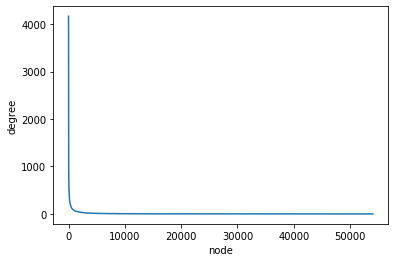

In [24]:
import matplotlib.pyplot as plt 
degrees = list(G.degree().values())
degrees.sort(reverse=True)
plt.plot(degrees)
plt.xlabel("node")
plt.ylabel("degree")

Text(0, 0.5, 'degree')

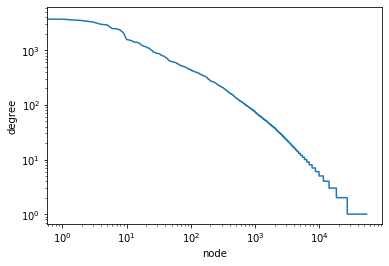

In [25]:
plt.loglog(degrees)
plt.xlabel("node")
plt.ylabel("degree")

Text(0, 0.5, 'number of nodes')

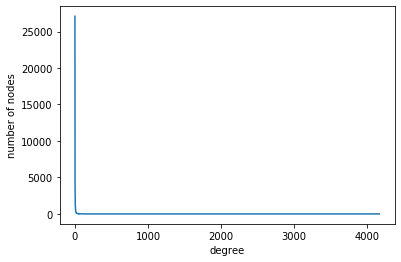

In [26]:
from collections import Counter
counter = Counter(degrees)
index = range(1, max(degrees)+1)
values = [counter[key] for key in index]
plt.plot(index, values)
plt.xlabel("degree")
plt.ylabel("number of nodes")

Text(0, 0.5, 'number of nodes')

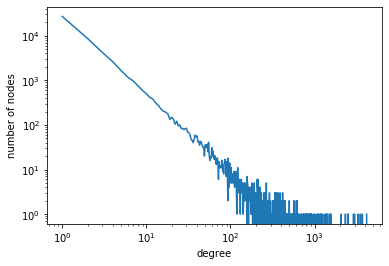

In [27]:
plt.loglog(index, values)
plt.xlabel("degree")
plt.ylabel("number of nodes")

In [41]:
nodes = set()
nodes_times, edges_times = [], []
edges = 0
times = []
for edge in G.stream_interactions():
        times.append(datetime.datetime.fromtimestamp(edge[3]).strftime('%Y-%m'))
        edges += 1
        edges_times.append(edges)
        nodes.add(edge[0])
        nodes.add(edge[1])
        nodes_times.append(len(nodes))

In [42]:
import numpy as np
def downsample_time(times, nodes_times, edges_times, target_samples):
    total_samples = len(times)
    interval = total_samples / target_samples
    indexes = np.floor(np.arange(1,target_samples+1) * interval - 1)
    node_sampled = [nodes_times[int(index)] for index in indexes]
    edge_sampled = [edges_times[int(index)] for index in indexes]
    time_sampled = [times[int(index)] for index in indexes]
    return node_sampled, edge_sampled, time_sampled
nodes, edges, timesample = downsample_time(times, nodes_times, edges_times, 12)

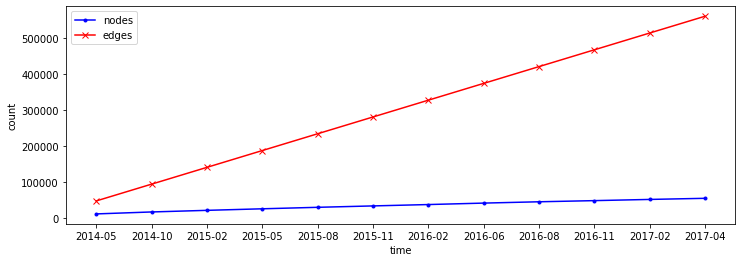

In [47]:
plt.figure(figsize=(12, 4))
plt.plot(timesample, nodes, 'b.-')
plt.xlabel("time")
plt.ylabel("count")
plt.plot(timesample, edges, 'rx-')
plt.xlabel("time")
plt.legend(["nodes", "edges"])

In [17]:
print('mean:', np.mean(degrees))
print('edges:', edges_times[-1])
print('nodes:', nodes_times[-1])
print("growth rate is", nodes_times[-1]/40, "nodes/month and", edges_times[-1]/40, "edges/month.")

mean: 8.683938973647711
edges: 561481
nodes: 54075
growth rate is 1351.875 nodes/month and 14037.025 edges/month.
